In [ ]:
###############################################################################################
# Author: Sayan Kumar Swar
# Published: 05/08/2025
# University of Rochester
###############################################################################################

### Load Required Libraries

In [15]:
%load_ext autoreload
%autoreload 2

import jax
import jaxopt
from jax import grad, jit, lax, nn
from jax import numpy as jnp
from jax import random, value_and_grad, vmap
from jax.example_libraries import optimizers
jax.config.update("jax_enable_x64", True)

from utils.sample_circle import *
from utils.gaussPulse import *
from utils.getSoundSpeed import *
from utils.coreFWI import *
from utils.visuals import *

import h5py
import numpy as np
import time as tt
from PIL import Image
import glob
import matplotlib.pyplot as plt 
from scipy.spatial import cKDTree
from scipy.interpolate import interp1d
from tqdm import tqdm
from IPython.display import display

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Load Recorded Channel Data Details

In [3]:
with h5py.File('data/RecordedData.mat', 'r') as f:
    x_np = f['x'][:]     
    y_np = f['y'][:]     
    C_np = f['C'][:]     
    x_circ_np = f['x_circ'][:]     
    y_circ_np = f['y_circ'][:]     
    tx_include_np = f['tx_include'][:]     
    time_np = f['time'][:]     
    channelData_np = f['channelData'][:]     

x = jnp.array(x_np)
y = jnp.array(y_np)
C = jnp.array(C_np)
x_circ = jnp.array(x_circ_np)
y_circ = jnp.array(y_circ_np)
tx_include = jnp.array(tx_include_np)
tx_include = tx_include.astype('int64')
tx_include = tx_include-1

time = jnp.array(time_np)
channelData_np = channelData_np.transpose(tuple(range(channelData_np.ndim))[::-1])
channelData = jnp.array(channelData_np)


An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


### Get the Sensor Locations to Include and the ones to Exclude

<class 'jaxlib.xla_extension.ArrayImpl'>


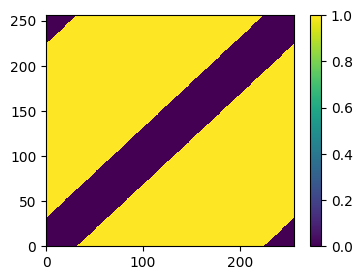

In [4]:
time_orig = time
time_orig = time_orig.reshape(-1)
numElements = len(x_circ_np)

numElemLeftRightExcl = 31
elemLeftRightExcl = np.arange(-numElemLeftRightExcl,numElemLeftRightExcl+1)
elemInclude = np.full((numElements, numElements), True)

for tx_element in range(0,numElements):
    elemLeftRightExclCurrent = elemLeftRightExcl + tx_element
    
    elemLeftRightExclCurrent[np.where(elemLeftRightExclCurrent<0)[0]] = (numElements) \
                                    + elemLeftRightExclCurrent[np.where(elemLeftRightExclCurrent<0)[0]]
    
    elemLeftRightExclCurrent[np.where(elemLeftRightExclCurrent>(numElements-1))[0]] = \
                        elemLeftRightExclCurrent[np.where(elemLeftRightExclCurrent>(numElements-1))[0]] - (numElements)
    
    elemInclude[tx_element,elemLeftRightExclCurrent] = False

elemInclude = jnp.array(elemInclude)
print(type(elemInclude))

plt.figure(figsize=(4,3))
plt.pcolormesh(elemInclude)
plt.colorbar()
plt.show()

### Setting up the Simulation

In [5]:
## Computational Grid (and Element Placement on Grid) for Reconstruction
dxi = 2.0e-3
dyi = 2.0e-3
xmax = 141e-3

xi = jnp.arange(-xmax, xmax + dxi, dxi)   
yi = xi.copy()                            
Nxi = xi.size
Nyi = yi.size
Xi, Yi = jnp.meshgrid(xi, yi, indexing='xy')

tree_x = cKDTree(xi[:, None])
tree_y = cKDTree(yi[:, None])

x_idx = tree_x.query(x_circ[:, None])[1]
y_idx = tree_y.query(y_circ[:, None])[1]
ind = x_idx * Nyi + y_idx
x_idx, y_idx, ind = jnp.array(x_idx), jnp.array(y_idx), jnp.array(ind)


## Determine Time Step
CFL = 0.3; #Hard-coded CFL number 
c_init = 1480; #Initial Homogeneous Sound Speed [m/s] Guess
dtmax = CFL*dxi/c_init; #CFL = c*dt/dx

## Transmit Pulse
fctr = 0.2e6; # Center Frequency [Hz]
fracBW = 0.5; # Fractional Bandwidth
tc = gauspuls_cutoff(fctr, fracBW)

## Time Axis
distmax = jnp.maximum(Nxi*dxi,Nyi*dyi)
c_min = jnp.min(C)
tend = tc + distmax / c_min
Nt = int(jnp.ceil(tend / dtmax)) + 1
dt = tend / (Nt - 1)
time = jnp.arange(0, Nt) * dt - tc
src_pulse = gauspuls(time, fctr, fracBW)

## Simulate Parameters
a0 = 0.02; #PML Constant
L_PML = 30.0e-3; #Thickness of PML  

In [6]:
## Interpolate Recorded Channel Data onto New Time Axis
## Need this part to Vectorize later
time_orig_np = time_np
time_new_np = np.array(time)

spline_interp = interp1d(
    time_orig_np.reshape(-1),
    channelData_np,
    kind='cubic',        
    axis=0,              
    fill_value='extrapolate' 
)
REC_DATA = spline_interp(time_new_np.reshape(-1))
print(REC_DATA.shape)

## Masking the Observations for the Receivers too close to the Transmitters
for tx_idx in range(0,len(tx_include)):
    for rx_idx in range(0,numElements):
        if ~elemInclude[tx_include[tx_idx],rx_idx]:
            REC_DATA[:, rx_idx, tx_idx] = 0

REC_DATA = jnp.array(REC_DATA)
REC_DATA_FT = jnp.fft.fft(REC_DATA, axis=0)

## Get the velocity estimation
VEL_ESTIM = c_init*jnp.ones([Nyi,Nxi])
SLOW_ESTIM = 1/VEL_ESTIM


(522, 256, 64)


In [7]:
## Creating the Mask to exclude boundary receivers
mask = elemInclude[tx_include.reshape(-1), :].T[None,:,:]
mask.shape

(1, 256, 64)

#### Visualizing the Source and Receiver Elements in the Array

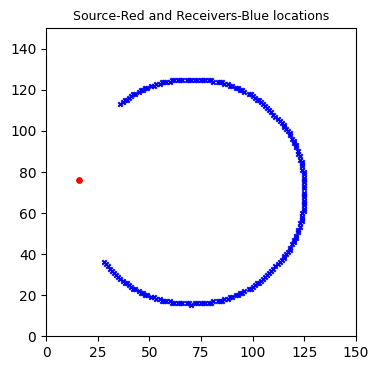

<Figure size 400x400 with 0 Axes>

In [19]:
fig, ax = plt.subplots(figsize=(4, 4))
masktemp = elemInclude[tx_include[0]].T
plt.scatter(x_circ[masktemp],   y_circ[masktemp],   c='blue',   label='included', s=10, marker='x')
plt.scatter(x_circ[tx_include[0]], y_circ[tx_include[0]], c='r',   label='included', s=15, marker='o')
plt.title('Source-Red and Receivers-Blue locations', fontsize=9)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_xlim([0, 150])
ax.set_ylim([0, 150])
title = ax.set_title('Transmitter Locations', fontsize=9)

display_handle = display(fig, display_id='wavefield')

c=0
for i in tx_include[1:]:
    masktemp = elemInclude[i].T
    plt.scatter(x_idx[i], y_idx[i], c='r',   label='included', s=15, marker='o')
    plt.scatter(x_idx[masktemp],   y_idx[masktemp],   c='blue',   label='included', s=10, marker='x')
    plt.title('Source-Red and Receivers-Blue locations', fontsize=9)
    plt.xlim([0, 150])
    plt.ylim([0, 150])

    display_handle.update(fig)
    plt.clf()
    tt.sleep(0.1)
    c+=1

plt.show()

### The Inverse Problem

In [17]:
getTimeStepping_vec_jit = jax.jit(getTimeStepping_vec)

@jax.jit
def simulate_fwd(tx:int, VEL_ESTIM: jnp.ndarray) -> jnp.ndarray:

    SRC = jnp.zeros([Nyi, Nxi, Nt])
    SRC = SRC.at[y_idx[tx], x_idx[tx], :].set(src_pulse)
    SRC = jnp.expand_dims(SRC,-1)

    WVFIELD_T = getTimeStepping_vec_jit(xi, yi, VEL_ESTIM, SRC, time, a0, L_PML, 0)         #Dim: Axial-Lateral-Time Series-1
    WVFIELD_T = jnp.squeeze(WVFIELD_T)                                                      #Dim: Axial-Lateral-Time Series

    REC_SIM = jnp.squeeze(WVFIELD_T[y_idx, x_idx, :],1).T                                   #Dim: Time Series-Receivers
    REC_SIM_FFT = jnp.fft.fft(REC_SIM, axis=0)

    return REC_SIM_FFT                                                                      #Dim: Time Series-Receivers

#simulate_fwd_all: Dim: Time Series-Receivers-Transmitters
simulate_fwd_all = jax.jit(jax.vmap(simulate_fwd, in_axes=(0,None), out_axes=-1))


@jax.jit
def loss_function(VEL_ESTIM):
    
    ## Calling Forward Operation
    pred = simulate_fwd_all(tx_include, VEL_ESTIM)                                          #Dim: Time Series-Receivers-Transmitters
    obs  = REC_DATA_FT                                                                      #Dim: Time Series-Receivers-Transmitters
    
    ## Masking the Receivers too close to the Transmitter (Observatons has been masked before)
    pred = pred * mask                                                          

    ## Permforming source estimation
    num = jnp.sum(jnp.conj(pred) * obs, axis=(1))                                           #Dim: Time Series-1-Transmitters
    den = jnp.sum(jnp.conj(pred) * pred, axis=(1))                                          #Dim: Time Series-1-Transmitters
    alpha = num / den                                
    pred_corr = pred * alpha[:, None, :]
    
    ## Converting to Time Domain Back: but not needed now
    #pred_corr = jnp.real(jnp.fft.ifft(pred_corr, axis=0))
    #obs = jnp.real(jnp.fft.ifft(obs, axis=0))

    ## Calculating the Loss and the Loss Abs Frobenius Norm
    resid = pred_corr - obs
    return jnp.vdot(resid, resid).real


loss_fn_jit = jax.jit(loss_function)


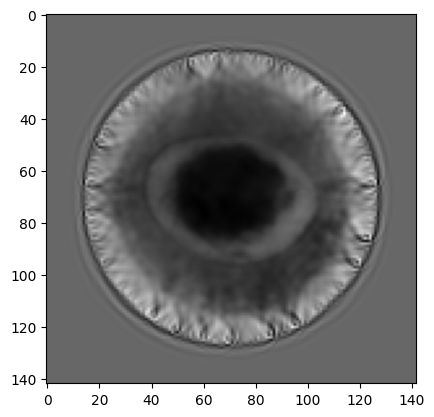

In [18]:
## Checking the Initial Gradient of the Image
grad_img = jax.grad(loss_fn_jit)(VEL_ESTIM)
plt.imshow(grad_img, cmap='gray')

In [19]:
## Printing Loss before Optimization
L0 = loss_fn_jit(VEL_ESTIM)
g0 = jnp.linalg.norm(jax.grad(loss_fn_jit)(VEL_ESTIM))
print("initial loss:", L0, "grad norm:", g0)

initial loss: 2.682319869842298e-08 grad norm: 1.286788995253227e-11


In [20]:
## Running Optimization
solver = jaxopt.LBFGS(fun=loss_fn_jit, maxiter=20, tol=1e-20)
result = solver.run(VEL_ESTIM)  
VEL_opt = result.params

In [21]:
## Printing loss after optimization ~ 40 mins to run 20 iterations
## But velocity estimate has a bigger range
Lopt = loss_fn_jit(VEL_opt)
print("final loss", Lopt)

final loss 8.341712413649864e-09


### Plot Results

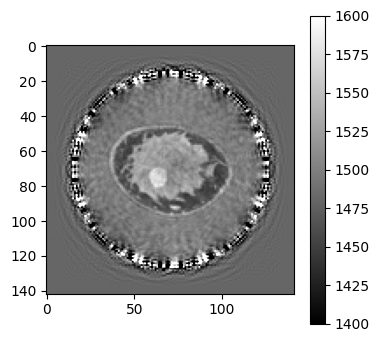

In [27]:
fig, ax = plt.subplots(figsize=(4, 4))
im = ax.imshow(
    VEL_opt,
    cmap='gray',
    aspect='equal',
    vmin=1400,
    vmax=1600
)
fig.colorbar(im)

### Additional Draft/Test Codes

In [16]:
# simulate_fwd_all = jax.vmap(simulate_fwd, in_axes=0, out_axes=-1)
# REC_SIM_FFT = simulate_fwd_all(tx_include)


# max_iterations = 20; tolLBFGS = 1e-6
# solver = jaxopt.LBFGS(fun=loss_function, tol=tolLBFGS)
# state = solver.init_state(VEL_ESTIM, REC_DATA_FT, tx_include)


# fig, ax = plt.subplots(figsize=(4, 4))
# im = ax.imshow(
#     VEL_ESTIM,
#     cmap='viridis',
#     aspect='equal'
# )

# display_handle = display(fig, display_id='wavefield')

# for iteration in range(max_iterations):
#     image_grad = jax.grad(loss_function,argnums=0)(VEL_ESTIM, REC_DATA_FT, tx_include)
#     VEL_ESTIM, state = solver.update(VEL_ESTIM, state, data=REC_DATA_FT)

#     im.set_data(VEL_ESTIM)
#     display_handle.update(fig)

#     if iteration ==2:
#         break
    
### Took 153 mins to run
# fig, ax = plt.subplots(figsize=(4, 4))
# im = ax.imshow(
#     VEL_ESTIM,
#     cmap='viridis',
#     aspect='equal'
# )

# display_handle = display(fig, display_id='wavefield')

# for iteration in range(max_iterations):
#     image_grad = jax.grad(loss_function,argnums=0)(VEL_ESTIM)
#     VEL_ESTIM, state = solver.update(VEL_ESTIM, state)

#     im.set_data(VEL_ESTIM)
#     display_handle.update(fig)


# max_iterations = 20
# solver = jaxopt.LBFGS(fun=loss_function)
# state = solver.init_state(VEL_ESTIM)

# for iteration in range(max_iterations):
#     image_grad = jax.grad(loss_function,argnums=0)(VEL_ESTIM)
#     VEL_ESTIM, state = solver.update(VEL_ESTIM, state)